In [5]:
library(repr)
library(ggplot2)
library(gutenbergr)
options(jupyter.plot_mimetypes = 'image/png')

# Parse the Gutemberg data base 

+ use the [gutemberger library](https://cran.r-project.org/web/packages/gutenbergr/README.html)
+ use the `grepl` command to filter the requiered data set

In [71]:
french_books = gutenberg_works(only_text=1, only_languages=1, languages="fr")
maupassant_books = french_books[grepl("Maupassant", french_books$author), ]
maupassant_books[c(1,2,3),]

gutenberg_id,title,author,gutenberg_author_id,language,gutenberg_bookshelf,rights,has_text
10746,Boule de Suif,"Maupassant, Guy de",306,fr,FR Nouvelles,Public domain in the USA.,TRUE
10775,Le Horla,"Maupassant, Guy de",306,fr,Gothic Fiction/FR Nouvelles,Public domain in the USA.,TRUE
11131,Pierre et Jean,"Maupassant, Guy de",306,fr,FR Littérature,Public domain in the USA.,TRUE


# Download the books
The result is a two column `tbl_df` dataframe from the `dplyr` library. It has one row per line of the text.
This dataframes are only a wrapper of the R dataframes to avoid long prints

In [72]:
maupassant_downloaded_books <- gutenberg_download(maupassant_books$gutenberg_id)

Determining mirror for Project Gutenberg from http://www.gutenberg.org/robot/harvest
Using mirror http://aleph.gutenberg.org


In [73]:
maupassant_downloaded_books[seq(76,85),]

gutenberg_id,text
10746,BOULE DE SUIF
10746,
10746,
10746,Pendant plusieurs jours de suite des lambeaux d'armee en deroute avaient
10746,"traverse la ville. Ce n'etait point de la troupe, mais des hordes"
10746,"debandees. Les hommes avaient la barbe longue et sale, des uniformes"
10746,"en guenilles, et ils avancaient d'une allure molle, sans drapeau, sans"
10746,"regiment. Tous semblaient accables, ereintes, incapables d'une pensee ou"
10746,"d'une resolution, marchant seulement par habitude, et tombant de fatigue"
10746,"sitot qu'ils s'arretaient. On voyait surtout des mobilises, gens"


In [74]:
write.csv(maupassant_downloaded_books,"maupassant.csv")

# Load downloaded data 

In [3]:
maupassant_downloaded_books = read.table("maupassant.csv",sep=",",header=1, encoding="UTF-8")

## Create corpus

In [6]:
library(NLP)
library(tm)

In [7]:
m.corpus <- Corpus(VectorSource(as.character(maupassant_downloaded_books$text)))
m.corpus

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 136214

In [8]:
attributes(m.corpus)
typeof(m.corpus)
excerpt = 100
m.corpus[[excerpt]]$content

$names
[1] "content" "meta"    "dmeta"  

$class
[1] "SimpleCorpus" "Corpus"

[1] "list"

[1] "ecus ou la longueur de leurs moustaches, couverts d'armes, de flanelle"

## Avoid encoding problems

In [9]:
m.corpus <- tm_map(m.corpus, function(x) iconv(enc2utf8(x), sub = "byte"))

## Lowering

In [10]:
m.corpus <- tm_map(m.corpus, content_transformer(tolower))
m.corpus[[excerpt]]$content

[1] "ecus ou la longueur de leurs moustaches, couverts d'armes, de flanelle"

## Remove punctuation and numbers

In [11]:
toSpace <- content_transformer(function (x , pattern) gsub(pattern, " ", x))
m.corpus <- tm_map(m.corpus, toSpace, "\'")
m.corpus <- tm_map(m.corpus, removeNumbers)
m.corpus <- tm_map(m.corpus, removePunctuation)
m.corpus[[excerpt]]$content

[1] "ecus ou la longueur de leurs moustaches couverts d armes de flanelle"

## Words - Documents Matrix

In [41]:
m.dtm <- TermDocumentMatrix(m.corpus)
inspect(m.dtm)

<<TermDocumentMatrix (terms: 40614, documents: 136214)>>
Non-/sparse entries: 711470/5531483926
Sparsity           : 100%
Maximal term length: 42
Weighting          : term frequency (tf)
Sample             :
      Docs
Terms  10112 10558 11344 15287 27505 39126 57442 60275 6715 8851
  dans     0     0     0     0     0     0     0     1    0    1
  des      0     0     0     1     0     0     2     0    0    0
  elle     0     0     0     0     0     0     0     0    0    0
  les      1     1     0     0     0     0     0     3    1    1
  pas      0     0     0     0     0     0     0     0    1    0
  que      0     1     2     0     0     0     2     0    0    0
  qui      1     2     0     0     2     1     0     0    0    0
  son      0     0     2     1     2     0     2     0    0    0
  sur      0     0     0     0     0     0     0     0    1    0
  une      2     0     0     1     0     0     0     0    1    0


In [57]:
excerpt <- 100
q <- m.dtm[,excerpt]
q <- as.vector(q)
lignes.non.vides <- which(q > 0)
inspect(m.dtm[lignes.non.vides,excerpt])

<<TermDocumentMatrix (terms: 7, documents: 1)>>
Non-/sparse entries: 7/0
Sparsity           : 0%
Maximal term length: 10
Weighting          : term frequency (tf)
Sample             :
            Docs
Terms        100
  armes        1
  couverts     1
  ecus         1
  flanelle     1
  leurs        1
  longueur     1
  moustaches   1


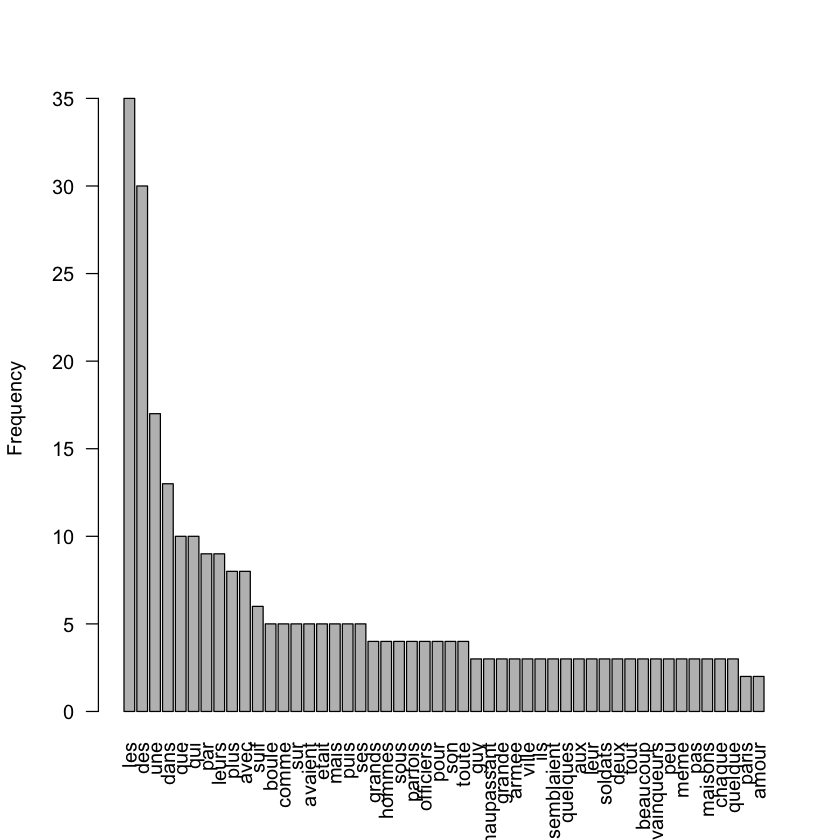

In [64]:
m <- as.matrix(m.dtm[1:1000,1:200])
m.freq <- rowSums(m)
m.freq.sorted <- sort(hp.freq, decreasing=TRUE)
barplot(m.freq.sorted[1:50], ylab="Frequency", las=2)

# Stop words

In [70]:
stopwords("french")
#french_stopwords <- c(stopwords("french"), "blablabla")
if(FALSE){
    lang <- c("danish", "dutch", "english", "finnish", "french", "german", "hungarian", "italian", "norwegian", "portuguese", "russian", "spanish", "swedish")
    ch <- "Voilà un test en français un peu plus long et on continue"
    ch.token <- sort(tolower(unlist(strsplit(ch, "[^[:alpha:]]"))))
    ch.token <- ch.token[ch.token != ""]
    tab.lang <- sapply(lang, function(x) length(intersect(ch.token, stopwords(x))))
    t(tab.lang)
    sprintf("My guess is: %s", lang[which(tab.lang == max(tab.lang))])
}

[1] "au"       "aux"      "avec"     "ce"       "ces"      "dans"    
  [7] "de"       "des"      "du"       "elle"     "en"       "et"      
 [13] "eux"      "il"       "je"       "la"       "le"       "leur"    
 [19] "lui"      "ma"       "mais"     "me"       "même"     "mes"     
 [25] "moi"      "mon"      "ne"       "nos"      "notre"    "nous"    
 [31] "on"       "ou"       "par"      "pas"      "pour"     "qu"      
 [37] "que"      "qui"      "sa"       "se"       "ses"      "son"     
 [43] "sur"      "ta"       "te"       "tes"      "toi"      "ton"     
 [49] "tu"       "un"       "une"      "vos"      "votre"    "vous"    
 [55] "c"        "d"        "j"        "l"        "à"        "m"       
 [61] "n"        "s"        "t"        "y"        "été"      "étée"    
 [67] "étées"    "étés"     "étant"    "suis"     "es"       "est"     
 [73] "sommes"   "êtes"     "sont"     "serai"    "seras"    "sera"    
 [79] "serons"   "serez"    "seront"   "serais"   "serait"   "serions" 
 [85] "seriez"   "seraient" "étais"    "était"    "étions"   "étiez"   
 [91] "étaient"  "fus"      "fut"      "fûmes"    "fûtes"    "furent"  
 [97] "sois"     "soit"     "soyons"   "soyez"    "soient"   "fusse"   
[103] "fusses"   "fût"      "fussions" "fussiez"  "fussent"  "ayant"   
[109] "eu"       "eue"      "eues"     "eus"      "ai"       "as"      
[115] "avons"    "avez"     "ont"      "aurai"    "auras"    "aura"    
[121] "aurons"   "aurez"    "auront"   "aurais"   "aurait"   "aurions" 
[127] "auriez"   "auraient" "avais"    "avait"    "avions"   "aviez"   
[133] "avaient"  "eut"      "eûmes"    "eûtes"    "eurent"   "aie"     
[139] "aies"     "ait"      "ayons"    "ayez"     "aient"    "eusse"   
[145] "eusses"   "eût"      "eussions" "eussiez"  "eussent"  "ceci"    
[151] "cela"     "celà"     "cet"      "cette"    "ici"      "ils"     
[157] "les"      "leurs"    "quel"     "quels"    "quelle"   "quelles" 
[163] "sans"     "soi"

In [66]:
m.corpus.sw <- tm_map(m.corpus, removeWords, stopwords('french'))

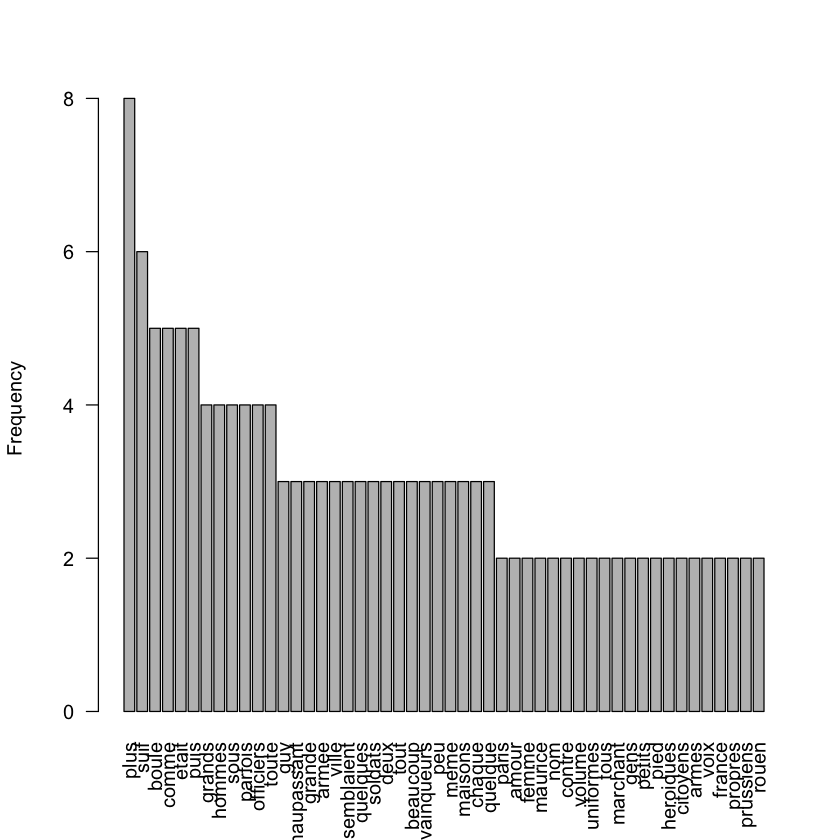

In [67]:
m.dtm.sw <- TermDocumentMatrix(m.corpus.sw)
m <- as.matrix(m.dtm.sw[1:1000,1:200])
m.freq <- rowSums(m)
m.freq.sorted <- sort(m.freq, decreasing=TRUE)
barplot(m.freq.sorted[1:50], ylab="Frequency", las=2)

## Steming